# 将掩码重新用于边界框

以下示例展示了 {mod}`torchvision.ops` 模块中可用的操作，这些操作可以将分割掩码转换为不同任务的对象定位注释（例如，将实例和全景分割方法使用的掩码转换为对象检测方法使用的边界框）。

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
ASSETS_DIRECTORY = "../../images"
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## 掩码
在实例分割和全景分割等任务中，掩码通常被定义，并且由这个包定义为多维数组（例如 NumPy 数组或 PyTorch 张量），具有以下形状：

      (num_objects, height, width)

其中 `num_objects` 是图像中注释对象的数量。每个 (height, width) 对象对应一个对象。例如，如果输入图像的尺寸为 224 x 224，并且有四个注释对象，则掩码注释的形状如下：

      (4, 224, 224).

掩码的很好的特性是它们可以很容易地重新用于解决各种对象定位任务的方法。

## 将掩码转换为边界框

例如，{func}`~torchvision.ops.masks_to_boxes` 操作可以将掩码转换为边界框，这些边界框可以用作 FasterRCNN 和 RetinaNet 等检测模型的输入。

将从 [PenFudan 数据集](https://www.cis.upenn.edu/~jshi/ped_html/) 中获取图像和掩码。

In [2]:
from torchvision.io import decode_image

img_path = os.path.join(ASSETS_DIRECTORY, "FudanPed00054.png")
mask_path = os.path.join(ASSETS_DIRECTORY, "FudanPed00054_mask.png")
img = decode_image(img_path)
mask = decode_image(mask_path)

这里的掩码表示为 PNG 图像，具有浮点值。每个像素被编码为不同的颜色，0 表示背景。请注意，图像和掩码的空间维度匹配。

In [3]:
print(mask.size())
print(img.size())
print(mask)

torch.Size([1, 498, 533])
torch.Size([3, 498, 533])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


In [4]:
# 获取唯一的颜色，因为这些将是对象 ID。
obj_ids = torch.unique(mask)

# 第一个 ID 是背景，所以删除它。
obj_ids = obj_ids[1:]

# 将颜色编码的掩码分割为一组布尔掩码。
# 请注意，如果掩码是浮点值而不是整数，此代码段也可以正常工作。
masks = mask == obj_ids[:, None, None]

现在掩码是布尔张量。在这种情况下，第一个维度是 3，表示实例的数量：图像中有 3 个人。其他两个维度是高度和宽度，它们等于图像的尺寸。对于每个实例，布尔张量表示特定像素是否属于图像的分割掩码。

In [5]:
print(masks.size())
print(masks)

torch.Size([3, 498, 533])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

可视化图像并绘制其对应的分割掩码。将使用 {func}`~torchvision.utils.draw_segmentation_masks` 来绘制分割掩码。

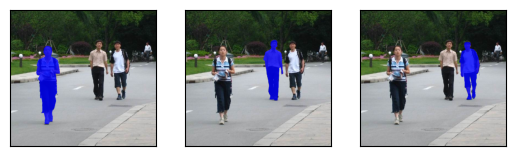

In [6]:
from torchvision.utils import draw_segmentation_masks

drawn_masks = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

show(drawn_masks)

要将布尔掩码转换为边界框。将使用 {func}`~torchvision.ops.masks_to_boxes`。它以 ``(xmin, ymin, xmax, ymax)`` 格式返回边界框。

In [7]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)

torch.Size([3, 4])
tensor([[ 96., 134., 181., 417.],
        [286., 113., 357., 331.],
        [363., 120., 436., 328.]])


正如形状所示，有 3 个框，格式为 ``(xmin, ymin, xmax, ymax)``。这些可以非常容易地使用 {func}`~torchvision.utils.draw_bounding_boxes` 实用程序进行可视化。

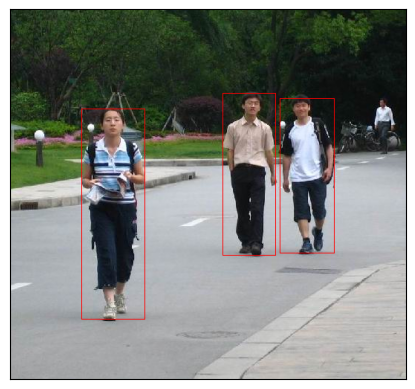

In [8]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

这些框现在可以直接被 torchvision 中的检测模型使用。这里是使用从 {func}`~torchvision.models.detection.fasterrcnn_resnet50_fpn` 加载的 Faster R-CNN 模型的演示。

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
print(img.size())

transforms = weights.transforms()
img = transforms(img)
target = {}
target["boxes"] = boxes
target["labels"] = labels = torch.ones((masks.size(0),), dtype=torch.int64)
detection_outputs = model(img.unsqueeze(0), [target])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ai/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


torch.Size([3, 498, 533])


## 将分割数据集转换为检测数据集

使用这个实用程序，将分割数据集转换为检测数据集变得非常简单。现在我们可以使用分割数据集来训练检测模型。同样，可以将全景数据集转换为检测数据集。

示例将数据集从 [PenFudan 检测教程](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) 中重新利用。

In [10]:
class SegmentationToDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = decode_image(img_path)
        mask = decode_image(mask_path)

        img = F.convert_image_dtype(img, dtype=torch.float)
        mask = F.convert_image_dtype(mask, dtype=torch.float)

        # We get the unique colors, as these would be the object ids.
        obj_ids = torch.unique(mask)

        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of boolean masks.
        masks = mask == obj_ids[:, None, None]

        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((masks.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target